In [6]:
# devtools::install_github("clairbarnes/rwwa")
library(rwwa)

In [51]:
# load & compile data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))

chirps <- load_ts("ts/panama_pr-wetseason_chirps.dat", col.names = c("year", "pr"))
acp <- load_ts("ts/panama_pr-wetseason_acp-sp.dat", col.names = c("year", "pr"))
mswep <- load_ts("ts/panama_pr-wetseason_mswep.dat", col.names = c("year", "pr"))

df_acp <- merge(merge(gmst, nino), acp)
df_chirps <- merge(merge(gmst, nino), chirps)
df_mswep <- merge(merge(gmst, nino), mswep)

cov_2023 <- df_acp[df_acp$year == 2023, c("gmst", "nino")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [53]:
chirps_gmst <- fit_ns("norm", "fixeddisp", df_chirps, "pr", c("gmst"), lower = T)
chirps_nino <- fit_ns("norm", "fixeddisp", df_chirps, "pr", c("gmst", "nino"), lower = T)

acp_gmst <- fit_ns("norm", "fixeddisp", df_acp, "pr", c("gmst"), lower = T)
acp_nino <- fit_ns("norm", "fixeddisp", df_acp, "pr", c("gmst", "nino"), lower = T)

acp_nino_sat <- fit_ns("norm", "fixeddisp", df_acp[df_acp$year >= 1979,], "pr", c("gmst", "nino"), lower = T)
mswep_nino <- fit_ns("norm", "fixeddisp", df_mswep, "pr", c("gmst", "nino"), lower = T)


In [44]:
# what do the model results look like?
res_chirps <- boot_ci(chirps_nino, cov_f = cov_2023, cov_cf = cov_cf)
res_acp <- boot_ci(acp_nino, cov_f = cov_2023, cov_cf = cov_cf)
res_acp_sat <- boot_ci(acp_nino_sat, cov_f = cov_2023, cov_cf = cov_cf)
res_mswep <- boot_ci(mswep_nino, cov_f = cov_2023, cov_cf = cov_cf)

In [62]:
all_res <- abind::abind("CHIRPS" = res_chirps, "MSWEP" = res_mswep, "ACP (1979-2023)" = res_acp_sat, "ACP (1881-2023)" = res_acp, along = 0)

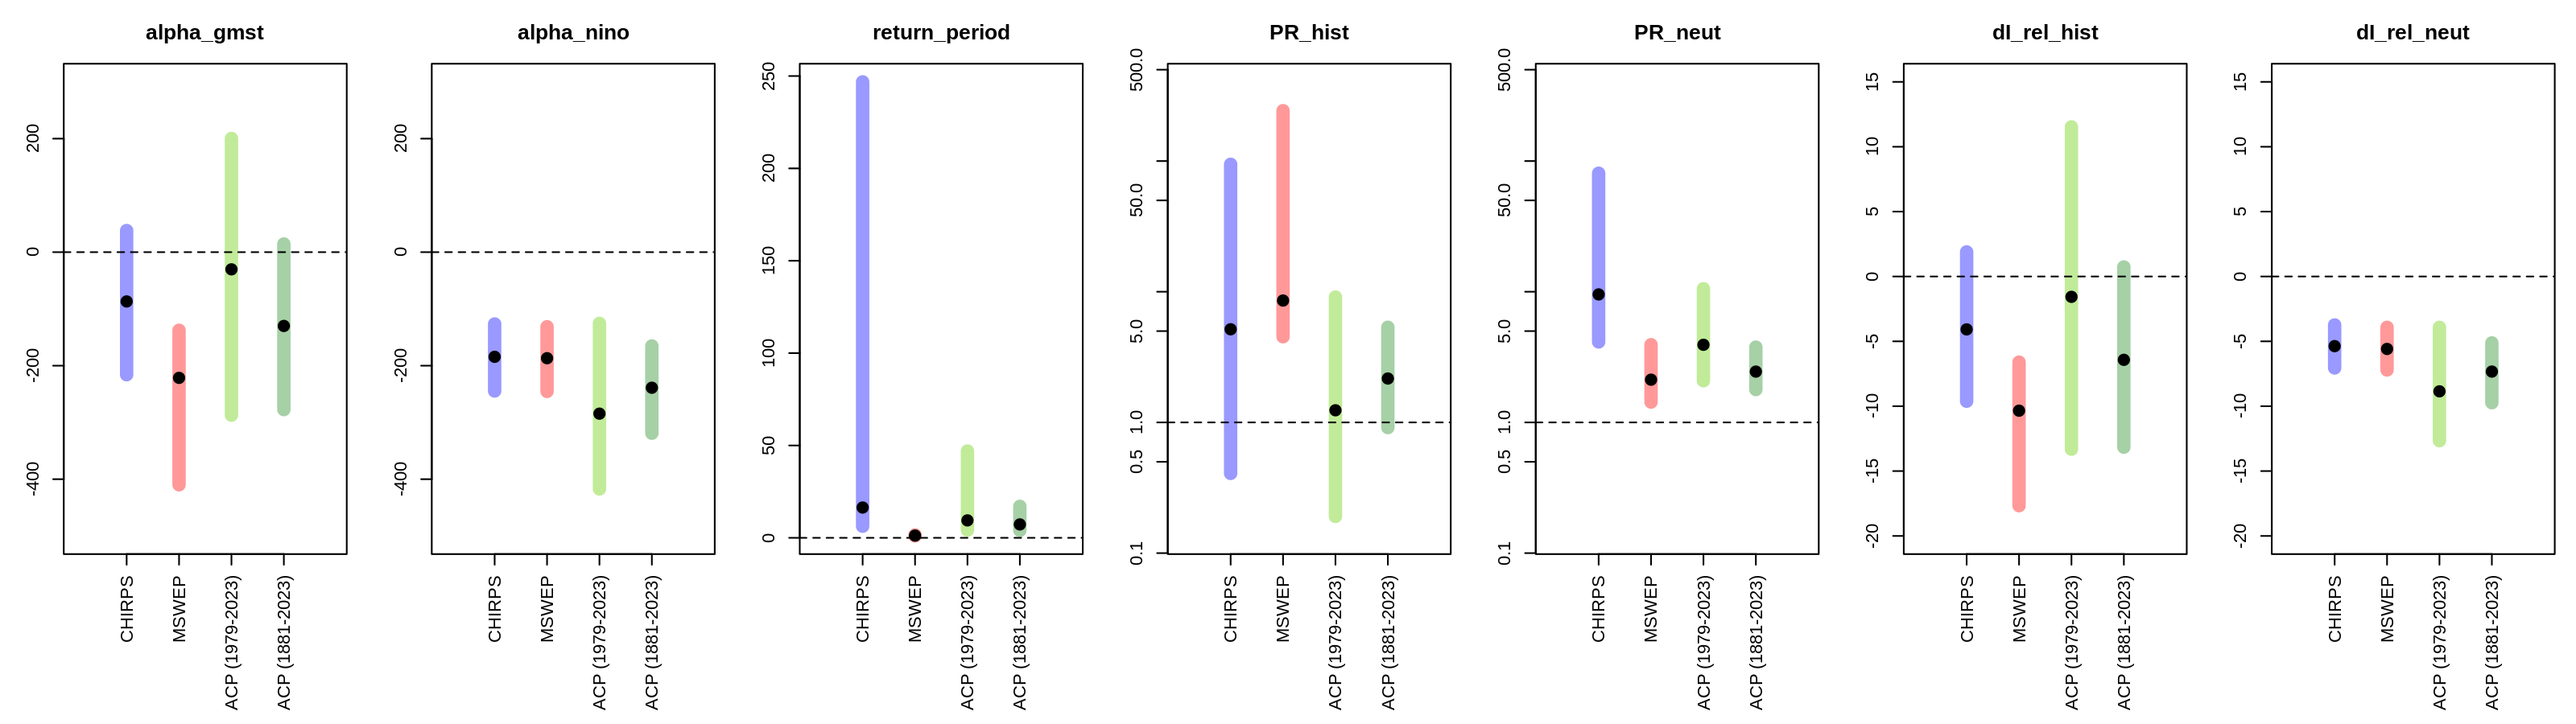

In [85]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,r,]
        ylim = range(res, na.rm = T)
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,grepl("alpha", colnames(all_res)),]))
        } 
        
        if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,grepl("dI_rel", colnames(all_res)),]))
        } 
        
        if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,grepl("PR", colnames(all_res)),]))))
        } else {
            h = 0
            logaxs = ""
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }